Upload Cleaned_IN_Table.csv and Cleaned_OUT_Table.csv (select both)...


Saving Cleaned_IN_Table.csv to Cleaned_IN_Table (2).csv
Saving Cleaned_OUT_Table.csv to Cleaned_OUT_Table (2).csv
Device: cuda | AMP: True
Loaded shapes: (14400, 5) (14400, 2)
Windowed shapes: (14369, 5, 32) (14369, 2) -> sequences: 14369
Train/Val sizes: 11495 2874

=== Training Ensemble ===

=== Member 1/1 (seed=42) ===
[Seed 42] Epoch 001/500 | TrainLoss 1.177607 | ValMSE 0.002173 | ValR2avg 0.4501 | R2targets [0.5323 0.368 ]
[Seed 42] Epoch 010/500 | TrainLoss 0.406448 | ValMSE 0.001326 | ValR2avg 0.6609 | R2targets [0.7007 0.6212]
[Seed 42] Epoch 020/500 | TrainLoss 0.303219 | ValMSE 0.001288 | ValR2avg 0.6710 | R2targets [0.7104 0.6315]
[Seed 42] Epoch 030/500 | TrainLoss -0.044008 | ValMSE 0.001130 | ValR2avg 0.7126 | R2targets [0.7513 0.674 ]
[Seed 42] Epoch 040/500 | TrainLoss -0.284140 | ValMSE 0.001018 | ValR2avg 0.7403 | R2targets [0.7724 0.7082]
[Seed 42] Epoch 050/500 | TrainLoss -0.400339 | ValMSE 0.000979 | ValR2avg 0.7508 | R2targets [0.7834 0.7181]
[Seed 42] Epoch 060

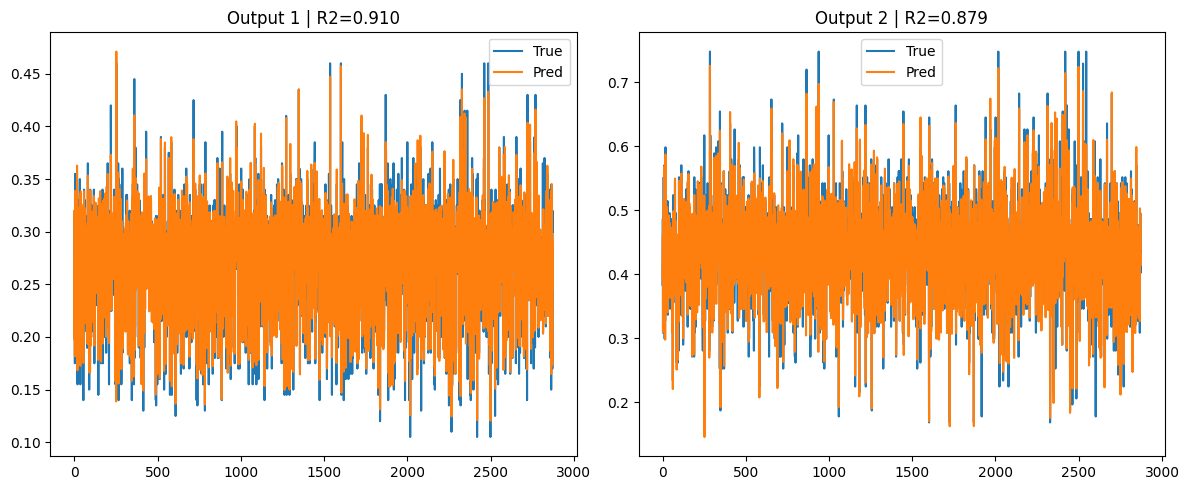

In [3]:

import os, time, math, copy, random, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings("ignore", category=FutureWarning)

IN_CSV = "Cleaned_IN_Table.csv"
OUT_CSV = "Cleaned_OUT_Table.csv"

SEEDS = [42]
SHUFFLE_SPLIT = True
TRAIN_FRAC = 0.8

WINDOW = 32
HORIZON = 0

EPOCHS = 500
BATCH_SIZE = 128
LR = 3e-4
WEIGHT_DECAY = 1e-5
PATIENCE = 40
GRAD_CLIP = 1.0

LSTM_HID = 64
LSTM_LAYERS = 1
NODE_EMB = 64
ATT_HEADS = 4
MLP_HID = 128
DROPOUT = 0.15

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
AMP = torch.cuda.is_available()

print("Device:", device, "| AMP:", AMP)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def quantile_clip(arr, q_low=0.001, q_high=0.999):
    lo = np.quantile(arr, q_low, axis=0)
    hi = np.quantile(arr, q_high, axis=0)
    return np.clip(arr, lo, hi)

if not (os.path.exists(IN_CSV) and os.path.exists(OUT_CSV)):
    raise FileNotFoundError("Upload Cleaned_IN_Table.csv and Cleaned_OUT_Table.csv to Colab and re-run.")

Xdf = pd.read_csv(IN_CSV)
Ydf = pd.read_csv(OUT_CSV)

if Xdf.shape[1] < 5 or Ydf.shape[1] < 2:
    raise ValueError("Expected >=5 input columns in Cleaned_IN_Table.csv and >=2 output columns in Cleaned_OUT_Table.csv")

X_raw = Xdf.iloc[:, :5].values.astype(np.float32)
Y_raw = Ydf.iloc[:, :2].values.astype(np.float32)
T_total = X_raw.shape[0]
print("Loaded shapes:", X_raw.shape, Y_raw.shape)

X_clipped = quantile_clip(X_raw, 0.002, 0.998)
Y_clipped = quantile_clip(Y_raw, 0.002, 0.998)

X_scaler = RobustScaler().fit(X_clipped)
Y_scaler = RobustScaler().fit(Y_clipped)

X = X_scaler.transform(X_clipped).astype(np.float32)
Y = Y_scaler.transform(Y_clipped).astype(np.float32)

def make_sequences(X, Y, window=32, horizon=0):
    T = len(X)
    end = T - window - horizon + 1
    if end <= 0:
        raise ValueError("Not enough rows for given WINDOW/HORIZON.")
    X_seq = np.zeros((end, 5, window), dtype=np.float32)
    Y_seq = np.zeros((end, 2), dtype=np.float32)
    for i in range(end):
        X_seq[i] = X[i:i+window].T
        Y_seq[i] = Y[i+window-1 + horizon]
    return X_seq, Y_seq

X_seq, Y_seq = make_sequences(X, Y, window=WINDOW, horizon=HORIZON)
print("Windowed shapes:", X_seq.shape, Y_seq.shape, "-> sequences:", X_seq.shape[0])

def compute_window_features(Xseq):
    N,F,W = Xseq.shape
    last = Xseq[:,:, -1]
    mean = Xseq.mean(axis=2)
    std = Xseq.std(axis=2)
    mn = Xseq.min(axis=2)
    mx = Xseq.max(axis=2)
    delta = Xseq[:,:, -1] - Xseq[:,:, 0]
    t = np.arange(W, dtype=np.float32)
    t_mean = t.mean()
    denom = ((t - t_mean)**2).sum()
    x_mean = Xseq.mean(axis=2, keepdims=True)
    slope = ((t - t_mean).reshape(1,1,W) * (Xseq - x_mean)).sum(axis=2) / (denom + 1e-9)
    feats = [last, mean, std, mn, mx, slope, delta]
    g = np.concatenate(feats, axis=1)
    return g.astype(np.float32)

G_seq = compute_window_features(X_seq)

class HorizonDataset(Dataset):
    def __init__(self, Xseq, Gseq, Yseq):
        self.X = torch.tensor(Xseq, dtype=torch.float32)
        self.G = torch.tensor(Gseq, dtype=torch.float32)
        self.Y = torch.tensor(Yseq, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.G[idx], self.Y[idx]

X_tr, X_va, G_tr, G_va, Y_tr, Y_va = train_test_split(
    X_seq, G_seq, Y_seq, train_size=TRAIN_FRAC, random_state=SEEDS[0], shuffle=SHUFFLE_SPLIT)

train_ds = HorizonDataset(X_tr, G_tr, Y_tr)
val_ds   = HorizonDataset(X_va, G_va, Y_va)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

print("Train/Val sizes:", len(train_ds), len(val_ds))

class NodeLSTMEncoder(nn.Module):
    def __init__(self, in_chan=1, hid=LSTM_HID, nlayers=LSTM_LAYERS, dropout=DROPOUT):
        super().__init__()
        self.lstm = nn.LSTM(input_size=in_chan, hidden_size=hid, num_layers=nlayers,
                            batch_first=True, dropout=dropout if nlayers>1 else 0.0, bidirectional=False)
        self.hid = hid
    def forward(self, x_bnw):
        out, (h_n, c_n) = self.lstm(x_bnw)
        last = h_n[-1]
        return last

class SimpleMultiHeadAttention(nn.Module):
    def __init__(self, dim_in, dim_out, heads=4, dropout=DROPOUT):
        super().__init__()
        assert dim_out % heads == 0
        self.heads = heads
        self.dk = dim_out // heads
        self.Wq = nn.Linear(dim_in, dim_out)
        self.Wk = nn.Linear(dim_in, dim_out)
        self.Wv = nn.Linear(dim_in, dim_out)
        self.fc_out = nn.Linear(dim_out, dim_out)
        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(self.dk)
        self.norm = nn.LayerNorm(dim_out)
    def forward(self, x):
        B, N, F = x.shape
        Q = self.Wq(x).view(B, N, self.heads, self.dk).transpose(1,2)
        K = self.Wk(x).view(B, N, self.heads, self.dk).transpose(1,2)
        V = self.Wv(x).view(B, N, self.heads, self.dk).transpose(1,2)
        attn_logits = torch.matmul(Q, K.transpose(-2,-1)) / self.scale
        attn = torch.softmax(attn_logits, dim=-1)
        attn = self.dropout(attn)
        out = torch.matmul(attn, V)
        out = out.transpose(1,2).contiguous().view(B, N, -1)
        out = self.fc_out(out)
        out = self.norm(out + x)
        out = nn.GELU()(out)
        return out

class GNN_LSTM_Model(nn.Module):
    def __init__(self, window=WINDOW, node_in=1, lstm_hid=LSTM_HID, lstm_layers=LSTM_LAYERS,
                 node_emb=NODE_EMB, att_heads=ATT_HEADS, mlp_hidden=MLP_HID, g_dim=35, out_dim=2, dropout=DROPOUT):
        super().__init__()
        self.window = window
        self.nodes = 5
        self.node_encoder = NodeLSTMEncoder(in_chan=node_in, hid=lstm_hid, nlayers=lstm_layers, dropout=dropout)
        self.node_proj = nn.Linear(lstm_hid, node_emb)
        self.att = SimpleMultiHeadAttention(dim_in=node_emb, dim_out=node_emb, heads=att_heads, dropout=dropout)
        self.readout_att = nn.Sequential(
            nn.Linear(node_emb, node_emb//2),
            nn.GELU(),
            nn.Linear(node_emb//2, 1)
        )
        self.mlp_global = nn.Sequential(
            nn.Linear(g_dim, mlp_hidden),
            nn.ReLU(),
            nn.BatchNorm1d(mlp_hidden),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden, mlp_hidden),
            nn.ReLU(),
        )
        comb_dim = node_emb + mlp_hidden
        self.shared = nn.Sequential(
            nn.Linear(comb_dim, comb_dim//2),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        self.head1 = nn.Sequential(
            nn.Linear(comb_dim//2, comb_dim//4),
            nn.GELU(),
            nn.Linear(comb_dim//4, 1)
        )
        self.head2 = nn.Sequential(
            nn.Linear(comb_dim//2, comb_dim//4),
            nn.GELU(),
            nn.Linear(comb_dim//4, 1)
        )
        self.log_vars = nn.Parameter(torch.zeros(out_dim))

    def forward(self, x_seq, g_feats):
        B, N, W = x_seq.shape
        x = x_seq.view(B*N, W, 1)
        node_h = self.node_encoder(x)
        node_h = self.node_proj(node_h)
        node_h = node_h.view(B, N, -1)
        h = self.att(node_h)
        scores = self.readout_att(h).squeeze(-1)
        weights = torch.softmax(scores, dim=1).unsqueeze(-1)
        hb = (h * weights).sum(dim=1)
        mg = self.mlp_global(g_feats)
        s = self.shared(torch.cat([hb, mg], dim=1))
        y1 = self.head1(s).squeeze(-1)
        y2 = self.head2(s).squeeze(-1)
        return torch.stack([y1, y2], dim=1)

def multitask_uncertainty_loss(pred, y, log_vars):
    losses = []
    for k in range(pred.size(1)):
        mse_k = F.mse_loss(pred[:,k], y[:,k], reduction='mean')
        loss_k = torch.exp(-log_vars[k]) * mse_k + log_vars[k]
        losses.append(loss_k)
    return sum(losses)

@torch.no_grad()
def evaluate(model, loader, y_scaler):
    model.eval()
    preds, trues = [], []
    for x, g, y in loader:
        x = x.to(device); g = g.to(device)
        out = model(x, g).cpu().numpy()
        preds.append(out); trues.append(y.numpy())
    preds = np.vstack(preds); trues = np.vstack(trues)
    preds_inv = y_scaler.inverse_transform(preds)
    trues_inv = y_scaler.inverse_transform(trues)
    mse = mean_squared_error(trues_inv, preds_inv)
    r2_per_target = r2_score(trues_inv, preds_inv, multioutput='raw_values')
    r2_avg = r2_score(trues_inv, preds_inv, multioutput='uniform_average')
    return mse, r2_per_target, r2_avg, preds_inv, trues_inv

def train_one_epoch(model, loader, optimizer, scaler=None):
    model.train()
    total = 0.0; n = 0
    for x, g, y in loader:
        x = x.to(device); g = g.to(device); y = y.to(device)
        optimizer.zero_grad(set_to_none=True)
        if scaler is not None:
            with torch.amp.autocast("cuda", enabled=AMP):
                pred = model(x, g)
                loss = multitask_uncertainty_loss(pred, y, model.log_vars)
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            if GRAD_CLIP is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            scaler.step(optimizer)
            scaler.update()
        else:
            pred = model(x, g)
            loss = multitask_uncertainty_loss(pred, y, model.log_vars)
            loss.backward()
            if GRAD_CLIP is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            optimizer.step()
        bs = x.size(0)
        total += loss.item() * bs
        n += bs
    return total / n

def train_model_for_seed(seed):
    set_seed(seed)
    model = GNN_LSTM_Model(window=WINDOW, node_in=1, lstm_hid=LSTM_HID, lstm_layers=LSTM_LAYERS,
                           node_emb=NODE_EMB, att_heads=ATT_HEADS, mlp_hidden=MLP_HID,
                           g_dim=G_seq.shape[1], out_dim=2, dropout=DROPOUT).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=2)
    scaler = torch.cuda.amp.GradScaler(enabled=AMP)
    best_val = np.inf; best_state = None; wait = 0
    train_losses = []; val_losses = []
    for epoch in range(1, EPOCHS + 1):
        tr_loss = train_one_epoch(model, train_loader, optimizer, scaler if AMP else None)
        scheduler.step(epoch + len(train_loader)/len(train_loader))
        val_mse, val_r2_t, val_r2_avg, _, _ = evaluate(model, val_loader, Y_scaler)
        train_losses.append(tr_loss); val_losses.append(val_mse)
        improved = val_mse < best_val - 1e-12
        if improved:
            best_val = val_mse
            best_state = {k:v.cpu() for k,v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
        if epoch % 10 == 0 or epoch == 1:
            print(f"[Seed {seed}] Epoch {epoch:03d}/{EPOCHS} | TrainLoss {tr_loss:.6f} | ValMSE {val_mse:.6f} | ValR2avg {val_r2_avg:.4f} | R2targets {np.round(val_r2_t,4)}")
        if wait >= PATIENCE:
            print(f"[Seed {seed}] Early stopping at epoch {epoch}. Best val MSE {best_val:.6f}")
            break
    if best_state is not None:
        model.load_state_dict({k:v.to(device) for k,v in best_state.items()})
    return model, best_val, train_losses, val_losses

all_member_preds = []
all_trues = None
all_member_metrics = []
print("\n=== Training Ensemble ===")
for i, seed in enumerate(SEEDS):
    print(f"\n=== Member {i+1}/{len(SEEDS)} (seed={seed}) ===")
    model, best_mse, train_losses, val_losses = train_model_for_seed(seed)
    all_member_metrics.append((train_losses, val_losses))
    mse_v, r2_t, r2_avg, preds_inv, trues_inv = evaluate(model, val_loader, Y_scaler)
    all_member_preds.append(preds_inv)
    all_trues = trues_inv
    print(f"[Seed {seed}] VAL MSE {mse_v:.6f} | R2 per target {np.round(r2_t,4)} | R2avg {r2_avg:.4f}")

member_preds_arr = np.array(all_member_preds)
ens_preds = member_preds_arr.mean(axis=0)
mse_ens = mean_squared_error(all_trues, ens_preds)
r2_ens = r2_score(all_trues, ens_preds, multioutput='raw_values')
r2_avg_ens = r2_score(all_trues, ens_preds)
print("\n=== Ensemble Results ===")
print("VAL MSE:", mse_ens)
print("R2 per target:", np.round(r2_ens,4))
print("R2 avg:", r2_avg_ens)

plt.figure(figsize=(12,5))
for k in range(2):
    plt.subplot(1,2,k+1)
    plt.plot(all_trues[:,k], label="True")
    plt.plot(ens_preds[:,k], label="Pred")
    plt.title(f"Output {k+1} | R2={r2_ens[k]:.3f}")
    plt.legend()
plt.tight_layout()
plt.show()
